In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from key_door import key_door_env, visualisation_env
from sac import utils, binary_maze

In [3]:
# Meister maze minimized MDP
tree_depth = 6
S, A = np.sum([2**x for x in range(tree_depth)]), 3

# Transition matrix (binary tree)
P = np.zeros((S, A, S))
for r in range(tree_depth - 1):
    for s in range(2**r):
        P[2**r - 1 + s, 0, 2**(r + 1) - 1 + 2 * s] = 1.0
        P[2**r - 1 + s, 1, 2**(r + 1) - 1 + 2 * s + 1] = 1.0
        if r > 0:
            P[2**r - 1 + s, 2, 2**(r - 1) - 1 + s // 2] = 1.0

# leaf nodes transition to previous level
for s in range(2**(tree_depth - 1)):
    P[2**(tree_depth - 1) - 1 + s, 2, 2**(tree_depth - 2) - 1 + s // 2] = 1.0

# Reward function (only at one leaf - action leading to the goal)
R = np.zeros((S, A))
R[2**(tree_depth - 1) - 1, 0] = 1.0

In [4]:
def draw_from_P_R(P, R=None, leaf_margin=0.05):
    import numpy as np
    import matplotlib.pyplot as plt

    S, A, _ = P.shape
    d = int(np.log2(S + 1))
    assert 2**d - 1 == S, "S must be 2^d - 1 (complete binary tree)."

    # x = depth; y from tidy layout (leaves evenly spaced, parents centered)
    x = np.zeros(S, dtype=float)
    y = np.zeros(S, dtype=float)

    # assign x by depth (breadth-first / heap indexing implies depth via floor(log2(s+1)))
    for r in range(d):
        start = 2**r - 1
        for i in range(2**r):
            s = start + i
            x[s] = r

    # leaves: indices [2^(d-1)-1, ..., 2^d-2]
    leaf_start = 2**(d - 1) - 1
    n_leaves = 2**(d - 1)
    # evenly spaced with a bit of top/bottom margin
    ys = np.linspace(leaf_margin, 1 - leaf_margin, n_leaves)
    for k in range(n_leaves):
        s_leaf = leaf_start + k
        y[s_leaf] = ys[k]

    # internal nodes: y = average of children (ensures balanced branches)
    for r in range(d - 2, -1, -1):
        start = 2**r - 1
        for i in range(2**r):
            s = start + i
            left = 2 * s + 1
            right = left + 1
            y[s] = 0.5 * (y[left] + y[right])

    # draw
    fig, ax = plt.subplots(figsize=(1.0, 1.5))

    # edges from P
    for s in range(S):
        for a in range(A):
            targets = np.where(P[s, a] > 0)[0]
            for t in targets:
                ax.plot([x[s], x[t]], [y[s], y[t]], linewidth=0.5, color="gray")

    # nodes
    ax.scatter(x, y, s=1, zorder=3, edgecolor="black", facecolor="black")

    # highlight rewards (mark source states that have any rewarded action)
    if R is not None:
        rewarding_states = np.unique(np.where(R > 0)[0])
        for s in rewarding_states:
            ax.scatter(x[s], y[s], s=1, zorder=4, edgecolor="red", facecolor="red", linewidth=2)

    ax.set_axis_off()

    fig.savefig("meister_tree_mdp.pdf", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()


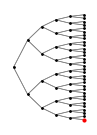

In [5]:
draw_from_P_R(P, R)

In [6]:
blocks, label = utils.deterministic_bisimulation(P, R)

In [7]:
blocks

[[0],
 [1],
 [2],
 [3],
 [4],
 [5, 6],
 [7],
 [8],
 [9, 10],
 [11, 12, 13, 14],
 [15],
 [16],
 [17, 18],
 [19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28, 29, 30],
 [31],
 [32],
 [33, 34],
 [35, 36, 37, 38],
 [39, 40, 41, 42, 43, 44, 45, 46],
 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]]

In [8]:
S, len(blocks)

(np.int64(63), 21)

In [9]:
maze_str, start_pos, reward_pos = binary_maze.generate_maze_from_mdp(tree_depth, P, R, maze_size=45)
print(maze_str)

#############################################
#############################################
#############################################
#############################################
#############################################
#####     #####     #####     #####    R#####
####### ######### ######### ######### #######
#######           #########           #######
####### #### #### ######### #### #### #######
#####     ## ##     #####     ## ##     #####
############ ################### ############
############ ################### ############
############                     ############
############ ######### ######### ############
############ ######### ######### ############
#####     ## ##     ## ##     ## ##     #####
####### #### #### #### #### #### #### #######
#######           #### ####           #######
####### ######### #### #### ######### #######
#####     #####     ## ##     #####     #####
###################### ######################
###################### ###########

In [10]:
start_pos, reward_pos

((22, 2), (5, 39))

In [11]:
with open("../sac/maps/meister_maze.txt", "w") as f:
    f.write(maze_str)

In [12]:
map_path = '../sac/maps/meister_maze.txt'
map_yaml_path = '../sac/maps/test_meister_maze.yaml'

# map_path = '../sac/maps/square_map.txt'
# map_yaml_path = '../sac/maps/square_map.yaml'

In [13]:
episode_timeout = 1000

In [14]:
env = key_door_env.KeyDoorEnv(map_ascii_path=map_path, map_yaml_path=map_yaml_path, representation="agent_position", episode_timeout=episode_timeout)
vis_env = visualisation_env.VisualisationEnv(env)

In [15]:
env.reset_environment(train=True)
vis_env.reset_environment(train=True)

(np.int64(2), np.int64(22), np.int64(0))

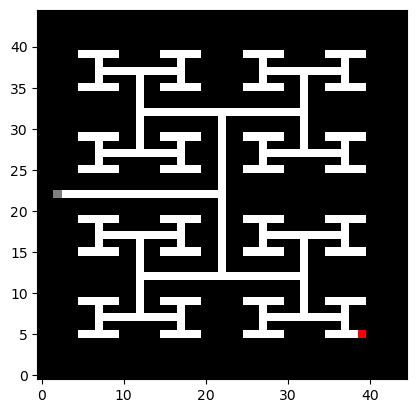

In [16]:
vis_env.render()

In [17]:
state_id_mapping = {state: i for i, state in enumerate(env.positional_state_space)}
id_state_mapping = {i: state for i, state in enumerate(env.positional_state_space)}

In [18]:
S = len(env.positional_state_space)
A = len(env.action_space)

P = np.zeros((S, A, S))
R = np.zeros((S, A))

reward_positions = list(env._rewards.keys())

for state in env.positional_state_space:
    state_index = state_id_mapping[state]
    if state not in reward_positions:
        for action in env.action_space:
            # set env and transition
            env.reset_environment(train=True)
            env.move_agent_to(state)
            reward, new_state = env.step(action)
            if reward > 0:
                print(f"From state {state} taking action {action} to state {new_state} with reward {reward}")
            # import pdb; pdb.set_trace()
            new_state_index = state_id_mapping[new_state[:2]]
            P[state_index][action][new_state_index] = 1
            R[state_index][action] = reward

From state (np.int64(38), np.int64(5)) taking action 2 to state (np.int64(39), np.int64(5), np.int64(1)) with reward 1.0224566081702322


In [19]:
blocks, label = utils.deterministic_bisimulation(P, R)

In [20]:
S, len(blocks)

(393, 393)

In [21]:
state_blocks, sa_blocks, state_label, sa_label, P_tilde, R_tilde, action_index_per_block = utils.joint_state_action_abstraction(P, R)

In [22]:
S, len(state_blocks)

(393, 142)

In [23]:
# create a dictionary mapping state coordinate tuple to state label
state_to_label = {id_state_mapping[i]: state_label[i] for i in range(len(state_label))}

vis_env.plot_heatmap_over_env(state_to_label, save_name='state_aggregation.pdf')
vis_env.plot_heatmap_over_env(state_to_label, save_name='state_aggregation.png')

/mnt/home/msrinath/workspace/state-abstraction-capacity/src/key-door-seblee97/key_door/visualisation_env.py:160: UserWarning: Adding colorbar to a different Figure <Figure size 200x200 with 1 Axes> than <Figure size 200x20 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, cax=ax, orientation='horizontal')
/mnt/home/msrinath/workspace/state-abstraction-capacity/src/key-door-seblee97/key_door/visualisation_env.py:160: UserWarning: Adding colorbar to a different Figure <Figure size 200x200 with 1 Axes> than <Figure size 200x20 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, cax=ax, orientation='horizontal')


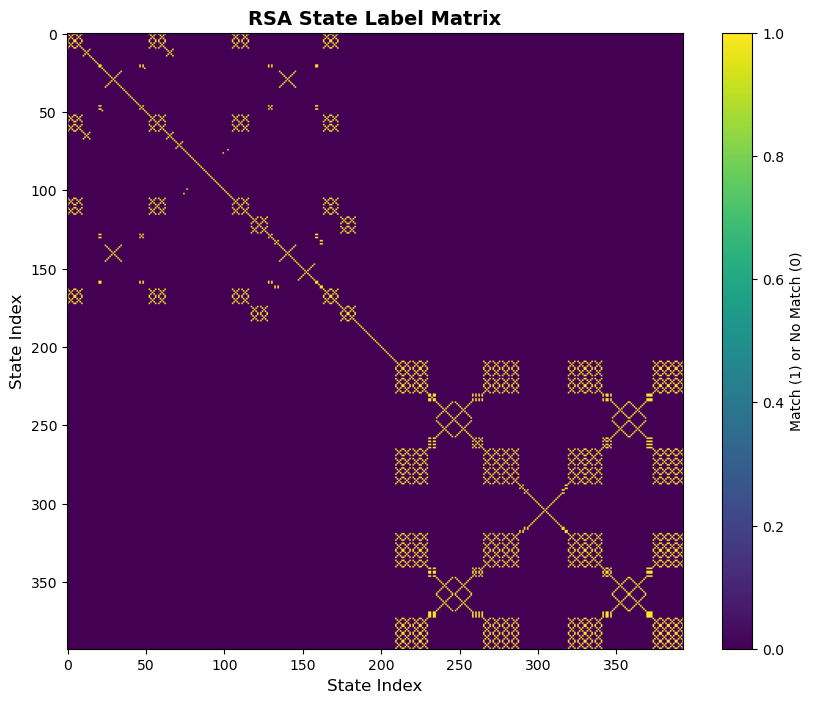

In [24]:
n = len(state_label)
rsa_matrix = np.zeros((n, n))

# Fill matrix: 1 where labels match, 0 otherwise
for i in range(n):
    for j in range(n):
        if state_label[i] == state_label[j]:
            rsa_matrix[i, j] = 1

# Alternatively, you can use broadcasting (more efficient):
# rsa_matrix = (state_labels[:, np.newaxis] == state_labels[np.newaxis, :]).astype(int)

# Visualize the matrix
plt.figure(figsize=(10, 8))
plt.imshow(rsa_matrix, cmap='viridis')
plt.colorbar(label='Match (1) or No Match (0)')
plt.title('RSA State Label Matrix', fontsize=14, fontweight='bold')
plt.xlabel('State Index', fontsize=12)
plt.ylabel('State Index', fontsize=12)
# plt.tight_layout()
plt.show()

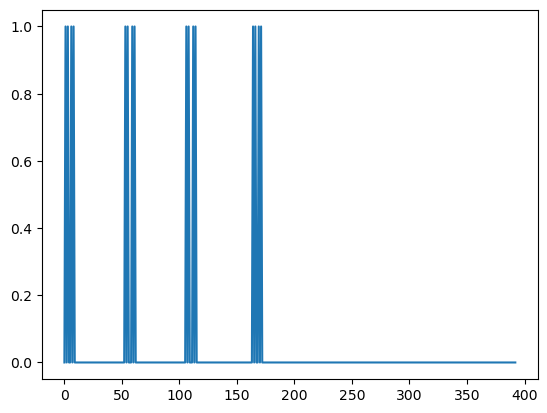

In [25]:
plt.plot(rsa_matrix[6])

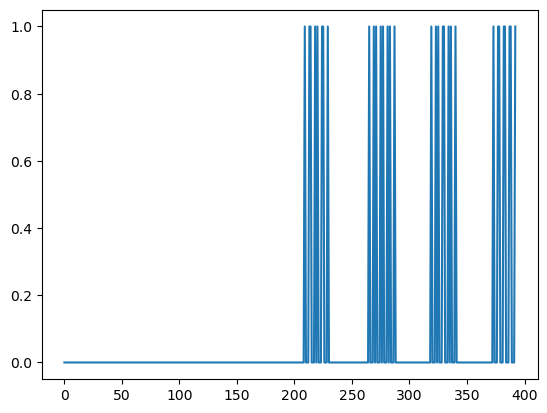

In [26]:
plt.plot(rsa_matrix[330])